# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [2]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [11]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [20]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f1,0)(0.0,0.0))
a, b = grad_f(1.0, 0.0)
print(a,b)

0.5403023058681398 2.0


In [15]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [16]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [3]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

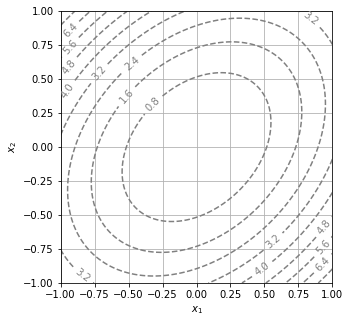

In [21]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [22]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

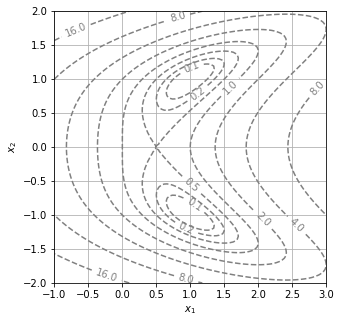

In [23]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [24]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

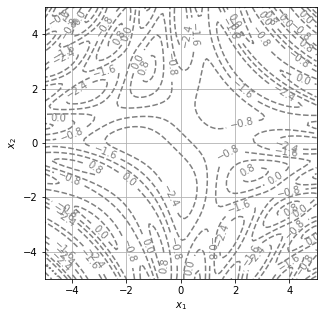

In [25]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

# Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [26]:
N = 100
eps = 0.00001 # 

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [27]:
def F(x, y):  # fonction de R^2 dans R^2 qui traduit les 2 équations
    return np.array([f1(x, y)-0.8, x - y]) # f(x, y)=c et y=x

def Newton(F , x0, y0, eps=eps, N=N):
    J_f = J(F)
    for i in range(N):
        mat = np.linalg.solve(J_f(x0, y0),F(x0, y0)) 
        x, y = [x0, y0] - np.transpose(mat)
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

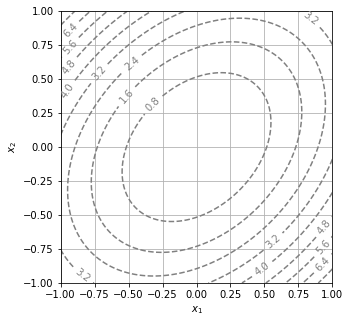

In [28]:
tab = Newton(F, 0.8, 0.8, 0.001, 100)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [29]:
def level_curve_1(f, x0, y0, delta=0.1, N=100, eps=eps):
    c = f(x0, y0)
    grad_f = grad(f)
    tab = np.zeros((2, N)) #tableau qui contiendra tous nos points
    tab[:,0] = x0, y0
    for i in range(1,N):
        def F(x, y):
            return np.array([f(x, y)-c, (x-x0)**2+(y-y0)**2 - delta**2])
            #on veut notre point sur le cercle de centre (x0,y0) de rayon delta
        
        a, b = grad_f(x0, y0)
        k = delta/np.linalg.norm(grad_f(x0, y0)) #delta/norme du gradient
        # (x1-x0, y1-y0) est orthogonal au gradient vers la droite, de norme delta
        x1, y1 = np.array([x0, y0]) + np.array([b, -a])*k
        
        tab[:,i] = Newton(F, x1, y1, eps, 10) #point dont la valeur en f est c, proche de (x1,y1)
        x0, y0 = tab[:,i] #on réitère avec (x0,y0) = (x1,y1)
    return tab

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [30]:
#Ajout d'une condition : si un point s'approche à une distance de 0.5*delta (élevé à 0.6 par sécurité)
#du point de départ, alors la boucle s'arrête. 
#Limite : si la courbe de niveau ne fait que s'approcher de ce point, sans avoir fini le contour.

def level_curve_2(f, x0, y0, delta=0.1, N=10, eps=eps):
    c = f(x0, y0)
    grad_f = grad(f)
    tab = np.zeros((2, N))
    tab[:,0] = x0, y0 
    for i in range(1,N):
        def F(x, y):
            return np.array([f(x, y)-c, (x-x0)**2+(y-y0)**2 - delta**2])
        a, b = grad_f(x0, y0)
        k = delta/np.linalg.norm(grad_f(x0, y0)) 
        x1, y1 = np.array([x0, y0]) + np.array([b, -a])*k
        tab[:,i] = Newton(F, x1, y1, eps, 10) 
        x0, y0 = tab[:,i]
        if np.linalg.norm(tab[:,0]-tab[:,i]) <= delta*0.6:  #condition de sortie boucle for
            #on ne prend que jes points jusqu'au ième, sinon ils bouclent
            return tab[:,:i]  
    return tab

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

In [31]:
# level_curve qui affiche les points trouvés, avec leurs gradients associés

def affichage(f, x0, y0) -> None:
    """affiche la comparaison entre les points trouvés à l'aide de level_curve et de display_contour"""
    c = f(x0, y0)
    tab, gradients = level_curve_affichage(f, x0, y0, c)
    afficher_points(f, c, tab, gradients)

def level_curve_affichage(f, x0, y0,c, delta=0.1, N=100, eps=eps):
    """renvoie la liste des points trouvés avec la méthode level_curve 
    et des gradients de f en ces points pour les afficher"""
    grad_f = grad(f)
    tab = np.zeros((2, N)) #tableau qui contiendra tous nos points
    tab[:,0] = x0, y0
    gradients = [] #tableau qui contient les gradients de f en chacun des points trouvés pour pouvoir les afficher
    
    for i in range(1,N):
        def F(x, y):
            return np.array([f(x, y)-c, (x-x0)**2+(y-y0)**2 - delta**2])
        
        a, b = grad_f(x0, y0)
        gradients.append(np.array([[x0,y0],[a,b]])) 
        #vecteur permettant construire le gradient : point d'origine et longueurs selon Ox et Oy
        k = delta/np.linalg.norm([a,b]) #delta/norme du gradient
        x1, y1 = np.array([x0, y0]) + np.array([b, -a])*k 
        #point à la distance delta de (x0,y0), orthogonalement au gradient vers la droite
        # norme(np.array([b, -a])*k) = norme([b,-a])*norme(k) = norme([b-a])*delta/norme([a,b]) = delta
        
        tab[:,i] = Newton(F, x1, y1, eps, 10) #point dont la valeur en f est c
        x0, y0 = tab[:,i]
        if np.linalg.norm(tab[:,0]-tab[:,i]) <= delta*0.6:
            #on ne prend que jes points jusqu'au ième, sinon ils bouclent
            return tab[:,:i], gradients
    return tab, gradients

def afficher_points(f, c, tab, gradients, n=100):  #fonction d'affichage des points et gradiants
    """affiche les points trouvés avec la méthode level_curve et la courbe de niveau avec display_contour pour les comparer"""
    x_min, x_max = min(tab[0]), max(tab[0])
    y_min, y_max = min(tab[1]), max(tab[1])
    #on prend les extrêmes pour essayer de couvrir la surface de niveau,
    #pour pouvoir représenter tous les points intéressants
    ecart_x = (x_max-x_min)/3
    ecart_y = (y_max-y_min)/3
    #écart à rajouter sur les côtés pour bien voir le graphe
    
    x = np.linspace(x_min-ecart_x,x_max+ecart_x,n)
    y = np.linspace(y_min-ecart_x,y_max+ecart_y,n)
    #points pour afficher la courbe de niveau
    display_contour(f, x, y, levels=[c]) #affichage courbe de niveaux
    
    plt.plot(tab[0],tab[1],'r.', label = 'points trouvés') 
    #affichage des points trouvés

    normes_gradients = np.array([np.linalg.norm(points[1]) for points in gradients])
    longueur = max(normes_gradients)/min(ecart_x,ecart_y)
    #longueur par laquelle les diviser pour qu'ils soient visibles, 
    #tout en gardant les proportions entre eux
    X,Y = [],[] #coordonnées des points
    VX, VY = [],[] # coordonnées suivant Ox et Oy des gradients
    for points in gradients:
        x0,y0 = points[0]
        a,b = points[1]/longueur #ajustement de la taille des gradiants
        X.append(x0)
        Y.append(y0)
        VX.append(x0+a)
        VY.append(y0+a)
    plt.quiver(X,Y,VX,VY, color="blue",  label="Vecteurs gradients")
    #affichage des vecteurs gradients
    
    plt.title(f'Courbe de niveau {c},\npour la fonction {f.__name__}')
    plt.legend()
    plt.show()

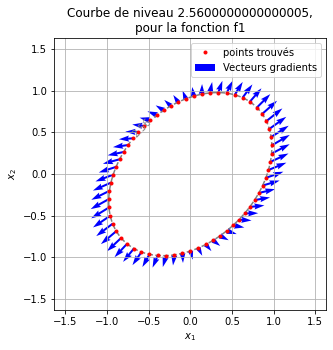

In [32]:
#affichage de level_curve pour la fonction f1
affichage(f1, 0.8, 0.8)

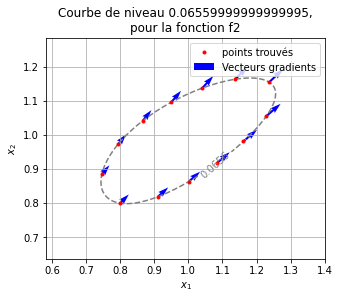

In [33]:
#affichage de level_curve pour la fonction f2
affichage(f2, 0.8, 0.8)

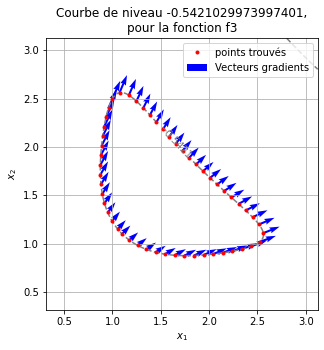

In [34]:
#affichage de level_curve pour la fonction f2
affichage(f3, 1.1, 1.1)

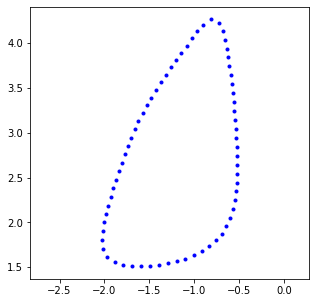

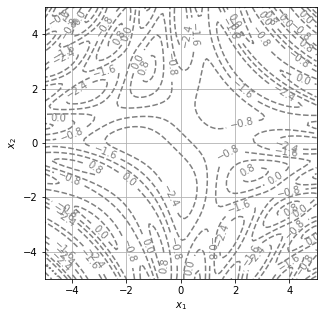

In [35]:
tab = level_curve_2(f3, -2.0, 2.0, 0.1, 200, 0.01)
plt.plot(tab[0,:], tab[1,:], 'b.')
plt.axis('equal')

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

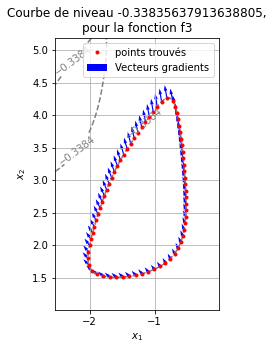

In [39]:
affichage(f3, -2.0, 2.0)

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [6]:
def aire_carres(f, c:float, h) -> float:
    """retourne l'aire trouvée par la méthode des carrés avec le pas h"""
    pt, lg = (-1, 1), 2     #coord. coin supérieur gauche du carré, longueur du coté
    nb = int(lg // h)   #nombre de cellules par côté
    y, x = np.indices((nb, nb)) #tableau de taille le nombre de points après découpage du carré
    #on place le tableau par rappport au coin pt
    x = (x + 0.5) * h + pt[0] 
    y = -(y + 0.5) * h + pt[1]
    
    somme = np.sum(f(x, y)<=c) #nombre de points du tableau dont l'image par f est <=c
    return somme*h*h #surface que cela repésente, 
                     #sachant que chaque point est au centre de son carré, donc représente le carré

def plot_err_carres(hi, n, divh, f, c, valeur_aire_reelle): #h initial, nb de pas, ratio entre pas, f° aire, f° cercle, niveau
    """affiche l'erreur entre la méthode des carrés et la méthode """
    h = [hi]    # largeur de h initiale
    for i in range(n):
        h.append(h[i]/divh)
        #la liste contient les pas que l'on veut tester
        
    err = []    # erreur en fonction de h
    for i in h:
        err.append(abs(aire_carres(f, c, i)-valeur_aire_reelle))
    
    plt.plot(h, err, 'b.')
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Pas h")
    plt.ylabel("Erreur |A_h - A|")

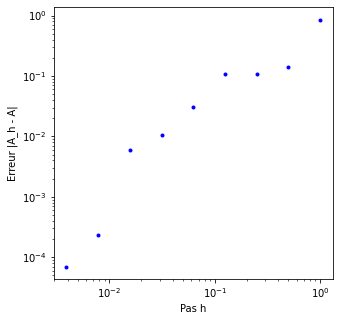

In [48]:
#application de la méthode des carrés à la fonction fc
def fc(x, y):
    return (x**2+y**2)**0.5

plot_err_carres(1, 8, 2, fc, 1, np.pi)

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [223]:
# On créé le même maillage que dans la fonction précédente.
# On parcourt ensuite chaque petit carré de ce maillage et on test si ses 4 coins vérifient f(x, y)<=c
# L'aire inf correspond à la somme de l'aire des carrés qui ont les 4 coins vérifiant f(x, y)<=c 
# L'aire sup correspond à la somme de l'aire des carrés qui ont au moins 1 coin vérifiant f(x, y)<=c


def area_squares_enc(f,c,h,pt,lg):#f°, niveau, pas, coord. coin sup gauche du carré, lg coté
    nb = round(lg / h) + 1   #nb de cellules
    y, x = np.indices((nb, nb))
    x = x * h + pt[0]
    y = -y * h + pt[1]
    m = f(x, y)<=c
    inf, sup = 0, 0
    for i in range(nb-1):
        for j in range(nb-1):
            corners = np.sum(m[i:i+2,j:j+2])
            if corners > 0:
                sup += 1
            if corners == 4:
                inf += 1
    inf, sup = inf*h**2, sup*h**2
    return inf, sup, sup-inf  #aire inf, aire sup, encadrement

area_squares_enc(fc,1,0.01, (-1, 1), 2)

(3.1016000000000004, 3.1812, 0.07959999999999967)

In [51]:
#tentative d'optimistion sans utiliser de boucle for, mais programme plus lent finalement.
#Temps mesuré avec la librairie time

def area_squares3(f,c,h):
    pt, lg = (-1.5, 1.5), 3    #coord. coin sup gauche du carré, lg coté
    nb = round(lg / h)    #nb de cellules
    y, x = np.indices((nb, nb))
    x = (x + 0.5) * h + pt[0]
    y = -(y + 0.5) * h + pt[1]
    m = f(x, y)<=c
    m2 = np.zeros((2*nb-2,2*nb-2))
    m2[0,:nb], m2[-1,:nb] = m[0], m[-1]
    m2[1:-2:2,:nb] = m[1:-1]
    m2[2:-1:2] = m2[1:-1:2]
    m2[:,-1] = m2[:,nb-1]
    m2[:,1:-1:2] = m2[:,1:nb-1]
    m2[:,2:-1:2] = m2[:,1:-1:2]
    lg = (nb-1)**2
    m2 = np.reshape(m2, ( lg ,2,2) )
    s = np.sum(m2, axis=(1,2))
    a = h**2
    inf, sup = sum(s==4)*a, sum(s>0)*a
    return inf, sup, sup-inf

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [146]:
def aire_triangle(contour, p):
    """retourne l'aire d'un ensemble délimité par une courbe fermé par la méthode des triangles"""
    tab, n, delta = contour #échantillonnage de la courbe de niveau
    #plt.plot(tab[0,:], tab[1,:], 'r.')
    a = 0
    for i in range(n-1):
        vec_oppo = tab[:,i]-tab[:,i+1]
        if np.linalg.norm(vec_oppo) < 2*delta:  
            #l'inverse correspond à la jonction de deux ensembles disjoints, qui forment l'ensemble étudié
            a += np.linalg.det([tab[:,i]-p, vec_oppo])
    return a/2


In [147]:
def plot_err_triangle(deltai,n,divd,f,p): #delta initial, nb de pas, ratio entre delta, f° aire, f° cercle
    """affiche l'erreur commise avec la méthode des triagles, selon differentes valeurs de delta"""
    delta = [deltai]    # delta initial
    for i in range(n):
        delta.append(delta[i]/divd)
    
    err = []    # erreur 
    for elt in delta:
        contour = cercle(elt, [0,0])
        err.append(abs(aire_triangle(contour, p)-np.pi))
    
    plt.plot(delta, err, 'b.')
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("delta")
    plt.ylabel("Erreur |B_n - pi|")

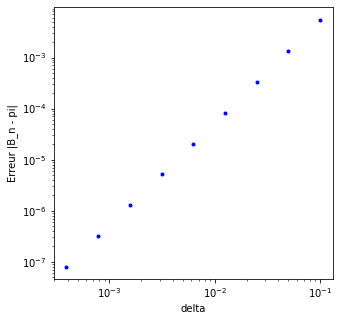

In [148]:
#méthode des triangles appliquée au cercle unité

def cercle(delta, centre):
    """renvoie un échantillonnage du cercle unité sens horaire"""
    t = np.linspace(2*np.pi, 0, int(2*np.pi/delta)) #échelonnage du [0, 2*pi]
    n = t.size
    tab = np.empty((2, n))
    tab[0,:], tab[1,:] = centre[0] + np.cos(t), centre[1] + np.sin(t) #échelonnage du cercle unité
    return tab, n, delta

aire_triangle(cercle(0.1, [0, 0]), np.array([0, 0]))
plot_err_triangle(0.1, 8, 2, cercle, np.array([0, 0]))

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

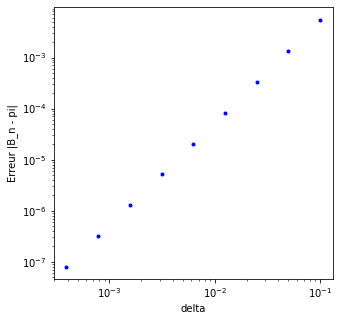

In [149]:
#affichage de l'erreur commise par la méthode des rectangles appliquée au cercle unité 
#avec le point [-2,0], externe au cercle
plot_err_triangle(0.1,8,2,cercle, np.array([-2, 0]))

In [150]:
#on constate exactement la même figure, que la méthode soit appliquée à un point interne ou externe au cercle

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [159]:
def union(delta):
    tab_1, n1, delta = cercle(delta, [1.5,0])
    tab_2, n2, delta = cercle(delta, [-1.5, 2])
    
    tab_union = np.c_[tab_1,tab_2]
    return tab_union, n1+n2, delta

In [160]:
aire_triangle(union(0.01), np.array([1, 0]) )

6.283080147054884

In [ ]:
#on constate bien que l'aire de deux cercles unité disjoints est de 2*pi

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [216]:
def area_triangles(x,y):
    """retourne l'aire d'un ensemble délimité par une courbe fermé par la méthode des triangles"""
    n, a = len(x), 0
    delta = 0.5
    for i in range(n-1):
        vec_oppo = np.array([x[i] - x[i+1], y[i] - y[i+1]])
        if np.linalg.norm(vec_oppo) < 2*delta:  
            a += np.linalg.det([np.array([x[i], y[i]]), vec_oppo])
    return abs(a/2)

In [221]:
tab, n, delta = cercle(0.001, [0, 0])
x, y = tab[0,:], tab[1,:]
area_triangles(x,y)

3.141592129793754

2.630507160125841

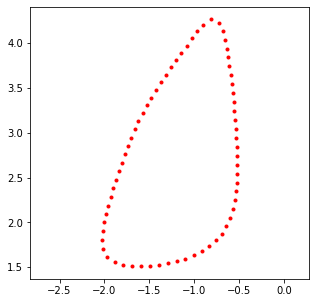

In [222]:
tab = level_curve_2(f3, -2.0, 2.0, 0.1, 1000, 0.01)
x, y = tab[0,:], tab[1,:]
plt.plot(x, y, 'r.')
plt.axis('equal')
area_triangles(x, y)

In [224]:
area_squares_enc(f3,1,0.01, (-2.5, 4.5), 3)

(8.9567, 8.9715, 0.014800000000001035)